# Topic Modeling
In this notebook we create a topic model for the text and also several topic models per article. The topic models are created as word clouds for easy visualization but tables are also possible.

Topic modeling overall depends on your usecase and what you would like to find out about your data, but I would not reccommend it for similarity search. For that usecase vector embeddings do a better, more reliable job. If you would like to get an idea of what the documents are about without having to read them entirely, or even if you would like to classify many documents without knowing beforehand what the classes might be, topic modeling is a good option. Though these days, even for that usecase embedding the documents with a trained word or document embedding model such as SBERT and then clustering said embeddings does a better job of splitting documents into classes. Another advantage of clustering embeddings is that you do not need to know the number of topics in advance

Still, many scientific articles in the humanities use topic modeling, so this introduction aims to show a minimal topic modeling example, which you can yourself play with and verify.

First let us import the necessary libraries.

### Imports

In [1]:
# packages to store and manipulate data
import pandas as pd
# plotting packages
import matplotlib.pyplot as plt
import re

import spacy
from tqdm import tqdm as tq
from random import shuffle
from gensim import corpora
from gensim.models.ldamodel import LdaModel

from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /home/genta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Then load the text and create a pandas dataframe.

In [2]:
pages = ["grs-001_1921_13__298_d.txt", "grs-001_1921_13__393_d.txt", "grs-001_1922_14__563_d.txt", "grs-001_1923_15__447_d.txt"]
input_text = []
for page in pages:
    with open("data/embedding_data/"+page,"r") as fin:
        input_text.append(fin.readlines())
df = pd.DataFrame(input_text, columns=["text"])

Let's have a look at the dataframe:

In [3]:
df.head()

,text
0,GEWERKSCHAFTLICHE RUNDSCHAU 39 Lohnabbau. In d...
1,GEWERKSCHAFTLICHE RUNDSCHAU 67 sie durchzuführ...
2,GEWERKSCHAFTLICHE RUNDSCHAU 117 Effektenbesitz...
3,"Bern, August XV. Jahrgang 1923 — Nr. 8 Gewerks..."


### Clean text

In [4]:
my_stopwords = nltk.corpus.stopwords.words('german')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@»«—°”’“'

# cleaning master function
def clean_text(text, bigrams=False):
    text = text.lower() # lower case
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text_token_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords

    text_token_list = [word_rooter(word) if '#' not in word else word
                        for word in text_token_list] # apply word rooter
    if bigrams:
        text_token_list = text_token_list+[text_token_list[i]+'_'+text_token_list[i+1]
                                            for i in range(len(text_token_list)-1)]
    text = ' '.join(text_token_list)
    return text

In [5]:
df['text'] = df.text.apply(clean_text) #this takes around 1m20s

In [6]:
df.head()

,text
0,gewerkschaftlich rundschau lohnabbau mittelpu...
1,gewerkschaftlich rundschau durchzuführen kont...
2,gewerkschaftlich rundschau effektenbesitz war...
3,bern august xv jahrgang nr gewerkschaftlich ...


### WordCloud
We do this type of topic modeling on the level of the entire text. Later we will also split it by document.

In this type of topic modeling, we don't do much by hand but can display the topics in a nice "word cloud". This can be used for visualizations in reports or presentations.

But first, once more, we decide on the number of topics:

In [7]:
N_TOPICS = 4

In [8]:
#nlp = spacy.load('en_core_web_sm') # for english text
nlp = spacy.load('de_core_news_sm')

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) 
            if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

# split into paragraphs
doc_clean = []
for doc in tq(df['text']):
    # split by paragraph
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))

# randomize document order
shuffle(doc_clean)

# creating the term dictionary
dictionary = corpora.Dictionary(doc_clean)
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
# dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)

# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
lda = LdaModel(doc_term_matrix, num_topics=N_TOPICS,
               id2word = dictionary, passes=3)
lda.show_topics(formatted=True)

/home/genta/Documents/notebooks_cs/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


[(0,
  '0.037*"fach" + 0.006*"betragen" + 0.006*"stundenlohn" + 0.004*"vorkriegslohn" + 0.004*"steigen" + 0.004*"frage" + 0.003*"august" + 0.003*"fall" + 0.003*"prei" + 0.003*"hoch"'),
 (1,
  '0.007*"frau" + 0.006*"arbeit" + 0.006*"woche" + 0.006*"niederkunft" + 0.005*"frage" + 0.004*"sech" + 0.004*"lösung" + 0.004*"mutterschutz" + 0.004*"million" + 0.004*"pro"'),
 (2,
  '0.011*"gesetz" + 0.007*"arbeit" + 0.005*"art" + 0.005*"international" + 0.005*"betrieb" + 0.005*"hoch" + 0.005*"regierung" + 0.004*"fall" + 0.004*"landwirtschaft" + 0.004*"gewerblich"'),
 (3,
  '0.003*"gesetz" + 0.002*"arbeit" + 0.002*"fach" + 0.002*"frau" + 0.002*"frage" + 0.001*"betrieb" + 0.001*"fall" + 0.001*"art" + 0.001*"woche" + 0.001*"hoch"')]

With the computations done, let us look at the nice word clouds :)

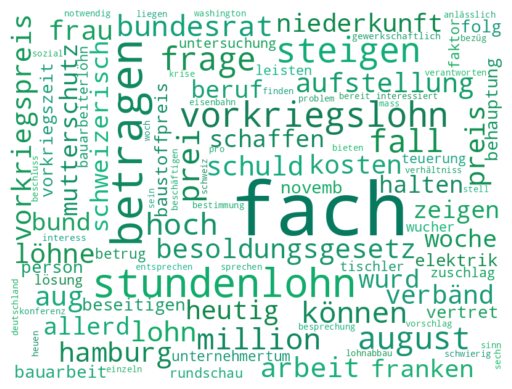

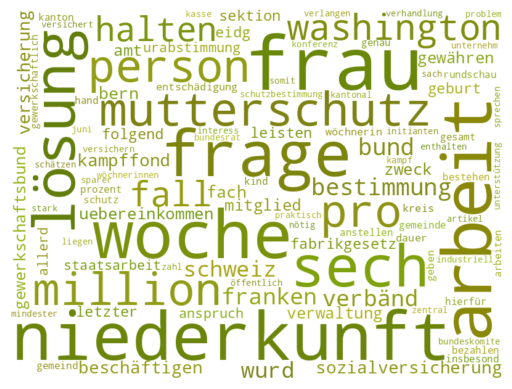

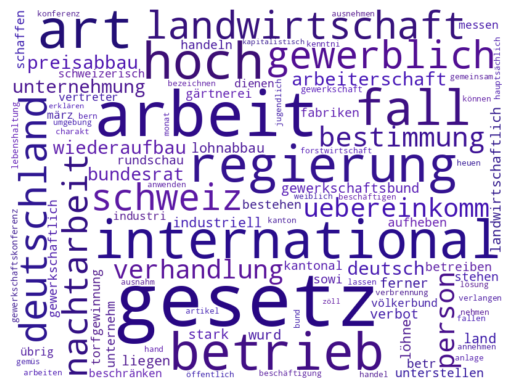

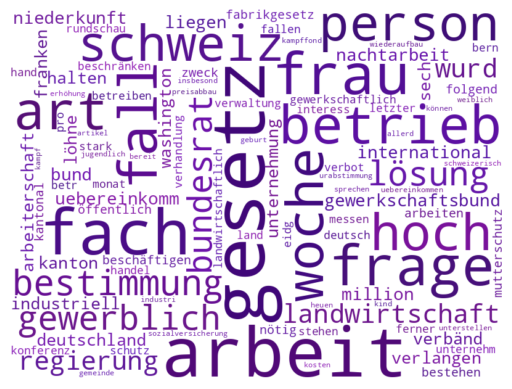

In [9]:
###
# LDA Word Clouds
###
#https://github.com/elliottash/nlp_lss_2023/blob/master/notebooks/03_topic_models.ipynb

# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=N_TOPICS,
                                 num_words=100,
                                 formatted=False):

    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None,
                  position=None, orientation=None,
                  font_path=None, random_state=None):
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)


    wordcloud = WordCloud(background_color="white",
                          ranks_only=True,
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

### "Manual" Topic Modeling
Here instead of using spacy we create everything ourselves.

Now we count the words. With this count vectorized we can get words that are mentioned in at most 90% of the documents with the parameter max_df=0.9 so as to avoid filler words. We can also ignore words that are mentioned in less than x% of documents using "min_df=x". But since we work with merely four documents, we will simply used our pre-cleaned text and not reduce it further.

#### Entire text

In [10]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(df['text']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names_out()

Now we can decide on how many topics we would like to extract and then call the model. In this case le'ts choose 4 topics, one per document, and see if the topic model can properly differentiate them.

In [11]:
number_of_topics = 4

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

model.fit(tf)

LatentDirichletAllocation(n_components=4, random_state=0)

This is a "helper function", it makes sure the result is printed in a nice way.

In [12]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

Now all we have to do is decide how many top words we would like to see per topic.

In [13]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,arbeit,14.3,gesetz,23.2,fach,47.2,arbeit,11.3
1,regierungen,10.2,art,11.3,betrug,9.2,niederkunft,11.2
2,deutschland,9.3,betrieb,10.3,stundenlohn,7.2,wochen,11.2
3,international,8.3,uebereinkommen,7.3,dagegen,6.3,ja,10.3
4,vertretern,6.3,nachtarbeit,7.2,gestiegen,5.3,frauen,9.3
5,arbeiterschaft,6.3,landwirtschaft,6.3,vorkriegslohn,5.2,zeit,9.3
6,preisabbau,6.2,denen,6.3,august,4.3,franken,8.3
7,lohnabbau,5.3,personen,6.3,worden,4.3,lösung,8.3
8,wiederaufbau,5.3,bundesrat,5.3,prei,4.2,nein,8.2
9,rp,5.3,o,5.3,löhne,4.2,mutterschutz,8.2


The topics themselves don't have a title except for "topic k" since this is done in a mathematical way where similar words are clustered together and not necessarily in a way where the model finds n topics and then splits the rest.

It seems that the topic modeling did naturally split the documents into four topics, but let's confirm by creating the topic models per document.

#### Per Document

In [14]:
for i in range(1,len(df)+1):
    # apply transformation
    tf_i = vectorizer.fit_transform(df['text'][i-1:i]).toarray()

    # tf_feature_names tells us what word each column in the matric represents
    tf_feature_names = vectorizer.get_feature_names_out()

    number_of_topics = 1

    model_i = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

    model_i.fit(tf_i)

    no_top_words = 10
    print(display_topics(model_i, tf_feature_names, no_top_words))
    print()

    Topic 0 words Topic 0 weights
0          arbeit            15.0
1     regierungen            11.0
2     deutschland            10.0
3   international             9.0
4  arbeiterschaft             7.0
5      preisabbau             7.0
6      vertretern             7.0
7       lohnabbau             6.0
8    wiederaufbau             6.0
9       deutschen             6.0

  Topic 0 words Topic 0 weights
0        arbeit            12.0
1   niederkunft            12.0
2        wochen            12.0
3            ja            11.0
4          zeit            10.0
5        frauen            10.0
6  mutterschutz             9.0
7       franken             9.0
8          sech             9.0
9          nein             9.0

   Topic 0 words Topic 0 weights
0           fach            48.0
1         betrug            10.0
2    stundenlohn             8.0
3        dagegen             7.0
4  vorkriegslohn             6.0
5      gestiegen             6.0
6         worden             5.0
7       

Indeed! Although we concatenated the articles before, even then our topic model was able to discern that they were different articles with different topics.